In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import datetime
import dateutil
import scipy.stats

from sklearn.model_selection import train_test_split
import torch
import re

%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df_pure = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/data.tsv', sep='\t', names=['category', 'text'])
df_arima = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/data_LSTM.tsv', sep='\t', names=['category', 'text'])
df_lstm = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/data_ARIMA.tsv', sep='\t', names=['category', 'text'])

dfs = [df_pure, df_arima, df_lstm]

In [4]:
def annotate_labels(df):
    possible_labels = df.category.unique()
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.category.replace(label_dict)
    return df


def split(df):
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )
    df['data_type'] = ['not_set']*df.shape[0]
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'
    return df

In [5]:
possible_labels = df_pure.category.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'decrease': 0, 'increase': 2, 'not relevant': 1}

In [6]:
dfs = list(map(annotate_labels, dfs))
dfs = list(map(split, dfs))

In [7]:
!pip install transformers

     |████████████████████████████████| 1.5MB 6.8MB/s 
     |████████████████████████████████| 2.9MB 38.1MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3b203b0fc398b8b2a0e9daded76aab0150f2b7e383702b7b31b9ebf96d82289c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [8]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score

In [9]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [11]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    accuracies = []

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        accuracies.append(len(y_preds[y_preds==label])/len(y_true))
    return accuracies
        
def overall_accuracy(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    nominator = 0
    denominator = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        nominator += len(y_preds[y_preds==label])
        denominator += len(y_true)
    return nominator/denominator

In [12]:
def df_to_data_loader(df):
    encode_data_val = tokenizer.batch_encode_plus(
        df[df.data_type=='val'].text.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=512,
        return_tensors='pt'
    )


    input_ids_val = encode_data_val['input_ids']
    attention_masks_val = encode_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    dataset_val = TensorDataset(input_ids_val,
                               attention_masks_val,
                               labels_val)


    dataloader_val = DataLoader(
        dataset_val,
        sampler=RandomSampler(dataset_val),
        batch_size=32
    )
    return dataloader_val

In [13]:
def evaluate(model, dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [14]:
dataloaders = list(map(df_to_data_loader, dfs))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [16]:
def eval_model(model_path, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
    model.to(device)
    pass
    model.load_state_dict(torch.load(model_path))
    
    _, prediction, true_values = evaluate(model, dataloader)
    acc_per_class = accuracy_per_class(prediction, true_values)
    acc = overall_accuracy(prediction, true_values)
    f1 = f1_score_func(prediction, true_values)
    return [[f1, acc, acc_per_class],[prediction, true_values]]

In [17]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [18]:
pure_models = list(listdir_nohidden('/content/gdrive/MyDrive/Fin-418-NLFF/models/pure'))
pure_models.sort(key=lambda f: int(re.sub('\D', '', f)))
print(pure_models)

['BERT_ft_epoch1.model', 'BERT_ft_epoch2.model', 'BERT_ft_epoch3.model', 'BERT_ft_epoch4.model', 'BERT_ft_epoch5.model', 'BERT_ft_epoch6.model', 'BERT_ft_epoch7.model', 'BERT_ft_epoch8.model', 'BERT_ft_epoch9.model', 'BERT_ft_epoch10.model']


cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 3/64

Class: not relevant
Accuracy: 563/601

Class: increase
Accuracy: 9/79



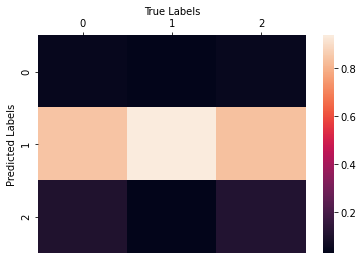

In [71]:
scores, [predictions, true_vals] = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/pure/' + pure_models[-1] , dataloaders[0])
class_mat = np.zeros((len(label_dict), len(label_dict)))

preds_flat = np.argmax(predictions, axis=1).flatten()

for i, pred in enumerate(preds_flat):
  class_mat[pred, true_vals[i]] += 1

for i in range(len(label_dict)):
  class_mat[:,i] = class_mat[:,i]/class_mat[:,i].sum()

ax = sns.heatmap(class_mat)
ax.xaxis.tick_top()
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
ax.xaxis.set_label_position('top') 
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/classmap_pure')
plt.show()

In [19]:
accs = np.zeros(len(pure_models))
accs_per_class = np.zeros(len(pure_models))
f1s = np.zeros(len(pure_models))
for i, model_path in enumerate(pure_models):
    scores, _ = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/pure/' + model_path, dataloaders[0])
    f1s[i] = scores[0]
    accs[i] = scores[1]
    accs_per_class[i] = np.mean(scores[2])

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/64

Class: not relevant
Accuracy: 601/601

Class: increase
Accuracy: 0/79

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

KeyboardInterrupt: ignored

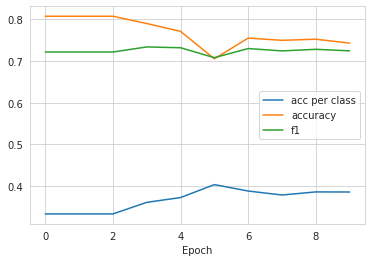

In [ ]:
sns.set_style("whitegrid")
sns.lineplot(data=accs_per_class, label='acc per class')
sns.lineplot(data = accs, label='accuracy')
sns.lineplot(data=f1s, label='f1')
plt.xlabel('Epoch')
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/scores_pure')
plt.show()

In [ ]:
print(accs[-1])
print(accs_per_class[-1])
print(f1s[-1])

0.7432795698924731
0.3859401437126589
0.7247679686062025


In [45]:
arima_models = list(listdir_nohidden('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_ARIMA'))
arima_models.sort(key=lambda f: int(re.sub('\D', '', f)))
print(arima_models)

['BERT_ft_epoch1.model', 'BERT_ft_epoch2.model', 'BERT_ft_epoch3.model', 'BERT_ft_epoch4.model', 'BERT_ft_epoch5.model', 'BERT_ft_epoch6.model', 'BERT_ft_epoch7.model', 'BERT_ft_epoch8.model', 'BERT_ft_epoch9.model', 'BERT_ft_epoch10.model']


cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 32/59

Class: not relevant
Accuracy: 465/483

Class: increase
Accuracy: 30/63



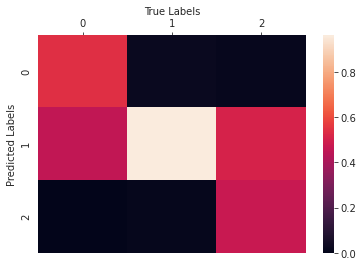

In [230]:
scores, [predictions, true_vals] = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_ARIMA/' + arima_models[-1] , dataloaders[1])
class_mat = np.zeros((len(label_dict), len(label_dict)))

preds_flat = np.argmax(predictions, axis=1).flatten()

for i, pred in enumerate(preds_flat):
  class_mat[pred, true_vals[i]] += 1

for i in range(len(label_dict)):
  class_mat[:,i] = class_mat[:,i]/class_mat[:,i].sum()

ax = sns.heatmap(class_mat)
ax.xaxis.tick_top()
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
ax.xaxis.set_label_position('top') 
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/classmap_arima')
plt.show()

In [78]:
arima_accs = np.zeros(len(arima_models))
arima_accs_per_class = np.zeros(len(arima_models))
arima_f1s = np.zeros(len(arima_models))
for i, model_path in enumerate(arima_models):
    scores, _ = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_ARIMA/' + model_path, dataloaders[1])
    arima_f1s[i] = scores[0]
    arima_accs[i] = scores[1]
    arima_accs_per_class[i] = np.mean(scores[2])

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/59

Class: not relevant
Accuracy: 483/483

Class: increase
Accuracy: 0/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/59

Class: not relevant
Accuracy: 483/483

Class: increase
Accuracy: 0/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 2/59

Class: not relevant
Accuracy: 482/483

Class: increase
Accuracy: 1/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 16/59

Class: not relevant
Accuracy: 475/483

Class: increase
Accuracy: 2/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 23/59

Class: not relevant
Accuracy: 470/483

Class: increase
Accuracy: 11/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 27/59

Class: not relevant
Accuracy: 468/483

Class: increase
Accuracy: 23/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 31/59

Class: not relevant
Accuracy: 467/483

Class: increase
Accuracy: 29/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 31/59

Class: not relevant
Accuracy: 465/483

Class: increase
Accuracy: 32/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 31/59

Class: not relevant
Accuracy: 466/483

Class: increase
Accuracy: 29/63

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 32/59

Class: not relevant
Accuracy: 465/483

Class: increase
Accuracy: 30/63



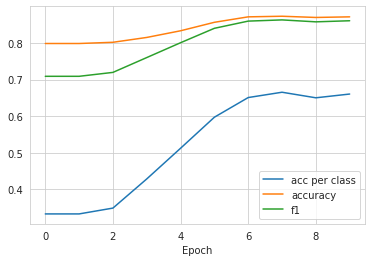

In [79]:
sns.set_style("whitegrid")
sns.lineplot(data=arima_accs_per_class, label='acc per class')
sns.lineplot(data=arima_accs, label='accuracy')
sns.lineplot(data=arima_f1s, label='f1')
plt.xlabel('Epoch')
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/scores_arima')
plt.show()

In [80]:
print(arima_accs[-1])
print(arima_accs_per_class[-1])
print(arima_f1s[-1])

0.8710743801652893
0.6604320922670223
0.8604248558650389


In [47]:
lstm_models = list(listdir_nohidden('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_LSTM'))
lstm_models.sort(key=lambda f: int(re.sub('\D', '', f)))
print(lstm_models)

['BERT_ft_epoch1.model', 'BERT_ft_epoch2.model', 'BERT_ft_epoch3.model', 'BERT_ft_epoch4.model', 'BERT_ft_epoch5.model', 'BERT_ft_epoch6.model', 'BERT_ft_epoch7.model', 'BERT_ft_epoch8.model', 'BERT_ft_epoch9.model', 'BERT_ft_epoch10.model']


cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 23/54

Class: not relevant
Accuracy: 483/506

Class: increase
Accuracy: 25/62



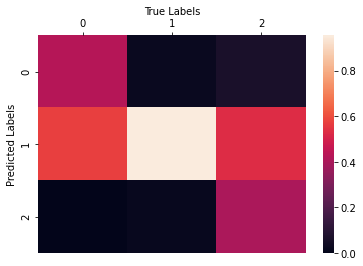

In [74]:
scores, [predictions, true_vals] = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_LSTM/' + lstm_models[-1] , dataloaders[2])
class_mat = np.zeros((len(label_dict), len(label_dict)))

preds_flat = np.argmax(predictions, axis=1).flatten()

for i, pred in enumerate(preds_flat):
  class_mat[pred, true_vals[i]] += 1

for i in range(len(label_dict)):
  class_mat[:,i] = class_mat[:,i]/class_mat[:,i].sum()

ax = sns.heatmap(class_mat)
ax.xaxis.tick_top()
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
ax.xaxis.set_label_position('top') 
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/classmap_lstm')
plt.show()

In [ ]:
lstm_accs = np.zeros(len(lstm_models))
lstm_accs_per_class = np.zeros(len(lstm_models))
lstm_f1s = np.zeros(len(lstm_models))
for i, model_path in enumerate(lstm_models):
    scores = eval_model('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_LSTM/' + model_path, dataloaders[2])
    lstm_f1s[i] = scores[0]
    lstm_accs[i] = scores[1]
    lstm_accs_per_class[i] = np.mean(scores[2])

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/54

Class: not relevant
Accuracy: 506/506

Class: increase
Accuracy: 0/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/54

Class: not relevant
Accuracy: 506/506

Class: increase
Accuracy: 0/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/54

Class: not relevant
Accuracy: 506/506

Class: increase
Accuracy: 0/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 0/54

Class: not relevant
Accuracy: 503/506

Class: increase
Accuracy: 4/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 5/54

Class: not relevant
Accuracy: 497/506

Class: increase
Accuracy: 12/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 11/54

Class: not relevant
Accuracy: 496/506

Class: increase
Accuracy: 14/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 16/54

Class: not relevant
Accuracy: 490/506

Class: increase
Accuracy: 19/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 17/54

Class: not relevant
Accuracy: 487/506

Class: increase
Accuracy: 25/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 22/54

Class: not relevant
Accuracy: 484/506

Class: increase
Accuracy: 25/62

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: decrease
Accuracy: 23/54

Class: not relevant
Accuracy: 483/506

Class: increase
Accuracy: 25/62



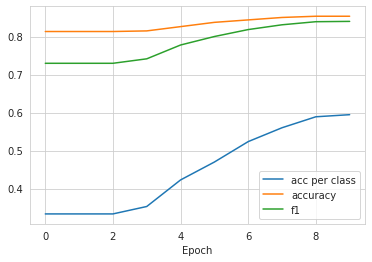

In [ ]:
sns.set_style("whitegrid")
sns.lineplot(data=lstm_accs_per_class, label='acc per class')
sns.lineplot(data = lstm_accs, label='accuracy')
sns.lineplot(data=lstm_f1s, label='f1')
plt.xlabel('Epoch')
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/scores_lstm')
plt.show()

In [ ]:
print(lstm_accs[-1])
print(lstm_accs_per_class[-1])
print(lstm_f1s[-1])

0.8536977491961415
0.5945657289743312
0.8401575996707779


In [81]:
def to_float(string: str):
    if type(string)==str:
        string = string.strip('[').strip(']')
    return float(string)

In [82]:
arima_data = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/prediction_arima_withdate.csv')
arima_data['Date'] = arima_data['Date'].apply(lambda x: dateutil.parser.parse(x))
arima_data.set_index('Date', inplace=True)
for col in arima_data.columns:
    arima_data[col] = arima_data[col].apply(lambda x: to_float(x))
lstm_data = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/lstm_pred.csv')
lstm_data['Date'] = lstm_data['Date'].apply(lambda x: dateutil.parser.parse(x))
lstm_data.set_index('Date', inplace=True)

In [86]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=0fa95991297748305fe2cf2206a61e61f3a2f4ff864a749720b0678ae06d1d0e
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [216]:
import yfinance as yf
yahoo_data = yf.download(list(arima_data.columns), start=arima_data.index.min().date(), end=arima_data.index.max().date(), progress=False)
true_returns = yahoo_data['Adj Close'].diff(-2)/yahoo_data['Adj Close']

In [217]:
def find_label(value: float):
  if value > 0.05:
    return 2
  elif value < -0.05:
    return 0
  else: 
    return 1

In [199]:
def accuracy_per_class_flat(labels, preds):
    accuracies = []
    for label in label_dict.values():
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        if len(y_true) > 0: 
          accuracies.append(len(y_preds[y_preds==label])/len(y_true))
    return np.average(accuracies)
        
def overall_accuracy_flat(labels, preds):
    nominator = 0
    denominator = 0

    for label in label_dict.values():
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        nominator += len(y_preds[y_preds==label])
        denominator += len(y_true)
    return nominator/denominator

In [200]:
true_labels = true_returns.applymap(find_label).dropna()
arima_data_labels = arima_data.applymap(find_label).dropna()
lstm_data_labels = lstm_data.applymap(find_label).dropna()

In [201]:
def all_scores(data, true):
  f1s = []
  for col in data.columns:
    f1s.append(f1_score(true[col].values, data[col].values, average='weighted'))
  
  accs = []
  for col in data.columns:
    accs.append(overall_accuracy_flat(true_labels[col].values, arima_data_labels[col].values))
  
  pc_accs = []
  for col in data.columns:
    pc_accs.append(accuracy_per_class_flat(true[col].values, data[col].values))
  return [np.average(f1s), np.average(accs), np.mean(pc_accs)]

In [202]:

all_scores(arima_data_labels, true_labels)

[0.9456366094842994, 0.962804549630897, 0.5805719435383447]

In [214]:
all_scores(lstm_data_labels[lstm_data_labels.index.isin(true_labels.index)], true_labels[true_labels.index.isin(lstm_data_labels.index)])

[0.9368231964226987, 0.962804549630897, 0.5845533065967025]